# The Final Project of CRP 5530 Land Use and Spatial Planning Methods
Made by Houpu_Li, 5/11/2024

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pandana.loaders import osm
import warnings
import pandana
warnings.filterwarnings('ignore')

In [3]:
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import seaborn as sns

In [4]:
import matplotlib.cm as cm
import networkx as nx
import osmnx
print(osmnx.__version__)
osmnx.config(log_file=True, log_console=True, use_cache=True)

1.9.1


In [5]:
import pandana

In [6]:
import requests
from io import StringIO

url = "https://www-users.cse.umn.edu/~tianhe/BIGDATA/UrbanCPS/PhoneData/PhoneData"

# Sending a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Assuming the data is in CSV format, read it into a DataFrame
    gps_data = pd.read_csv(StringIO(response.text))
else:
    print("Failed to retrieve data. Status code:", response.status_code)
    
gps_data.columns = ['id', 'time', 'lon', 'lat']
gps_data['datetime'] = pd.to_datetime('2013-10-22 ' + gps_data['time'])
gps_data

,id,time,lon,lat,datetime
0,55555556,23:53:07,114.026389,22.626042,2013-10-22 23:53:07
1,55555556,13:10:09,114.039792,22.574028,2013-10-22 13:10:09
2,55555556,16:08:30,113.805694,22.761389,2013-10-22 16:08:30
3,55555556,20:50:17,113.846597,22.772500,2013-10-22 20:50:17
4,55555557,23:39:23,114.043854,22.530757,2013-10-22 23:39:23
...,...,...,...,...,...
38218711,55969825,20:09:51,114.042708,22.524583,2013-10-22 20:09:51
38218712,55969825,20:08:41,114.042708,22.524583,2013-10-22 20:08:41
38218713,55969825,18:44:44,114.045069,22.525139,2013-10-22 18:44:44
38218714,55969825,18:44:15,114.045069,22.525139,2013-10-22 18:44:15


In [7]:
len(gps_data['id'].unique())

414271

In [8]:
min_datetime = gps_data['datetime'].min()
max_datetime = gps_data['datetime'].max()

print(f"Time Range: from {min_datetime} to {max_datetime}")

Time Range: from 2013-10-22 00:00:01 to 2013-10-22 23:59:59


In [9]:
from shapely.geometry import Point

# create a list of time bins
time_bins = pd.date_range('00:00', '23:59', freq='H').time  

# crate the label for each bin
labels = []
for t in time_bins[:-1]:
    start_time = pd.Timestamp.combine(pd.Timestamp.today().date(), t)  
    end_time = start_time + pd.Timedelta(hours=1)  
    labels.append(f"{start_time.strftime('%H:%M')}-{end_time.strftime('%H:%M')}")

# group the data into time bins
gps_data['time_bucket'] = pd.cut(gps_data['datetime'].dt.time, bins=time_bins, labels=labels, right=False, include_lowest=True)

# create the geometry column
geometry = [Point(xy) for xy in zip(gps_data['lon'], gps_data['lat'])]
geo_gps_data = gpd.GeoDataFrame(gps_data, geometry=geometry)
geo_gps_data.crs = "EPSG:4326"

In [10]:
geo_gps_data['time_bucket'].value_counts()

time_bucket
22:00-23:00    5751002
21:00-22:00    4145653
20:00-21:00    4101281
19:00-20:00    2578514
18:00-19:00    2559103
17:00-18:00    2408393
16:00-17:00    1798374
11:00-12:00     798033
10:00-11:00     784758
12:00-13:00     768653
13:00-14:00     756539
09:00-10:00     706540
15:00-16:00     646349
08:00-09:00     604836
00:00-01:00     566864
07:00-08:00     488082
01:00-02:00     450019
14:00-15:00     439007
02:00-03:00     403494
06:00-07:00     394274
03:00-04:00     370818
04:00-05:00     359674
05:00-06:00     357166
Name: count, dtype: int64

In [11]:
time_slots = geo_gps_data['time_bucket'].cat.categories.tolist()

# creat a loop to look for stores in each time slot
for i, slot in enumerate(time_slots):
    # create dataFrame，and name it as geo_fil_gps_{i}
    globals()[f'geo_fil_gps_{i}'] = geo_gps_data[geo_gps_data['time_bucket'] == slot].reset_index(drop=True)

In [12]:
# city network
G2 = osmnx.graph_from_place('Shenzhen, Guangdong Province, China')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G2)

# deleter the duplicated edges
gdf_edges = gdf_edges[~gdf_edges.duplicated(subset='geometry', keep='first')]
gdf_edges = gdf_edges.reset_index(drop=True)

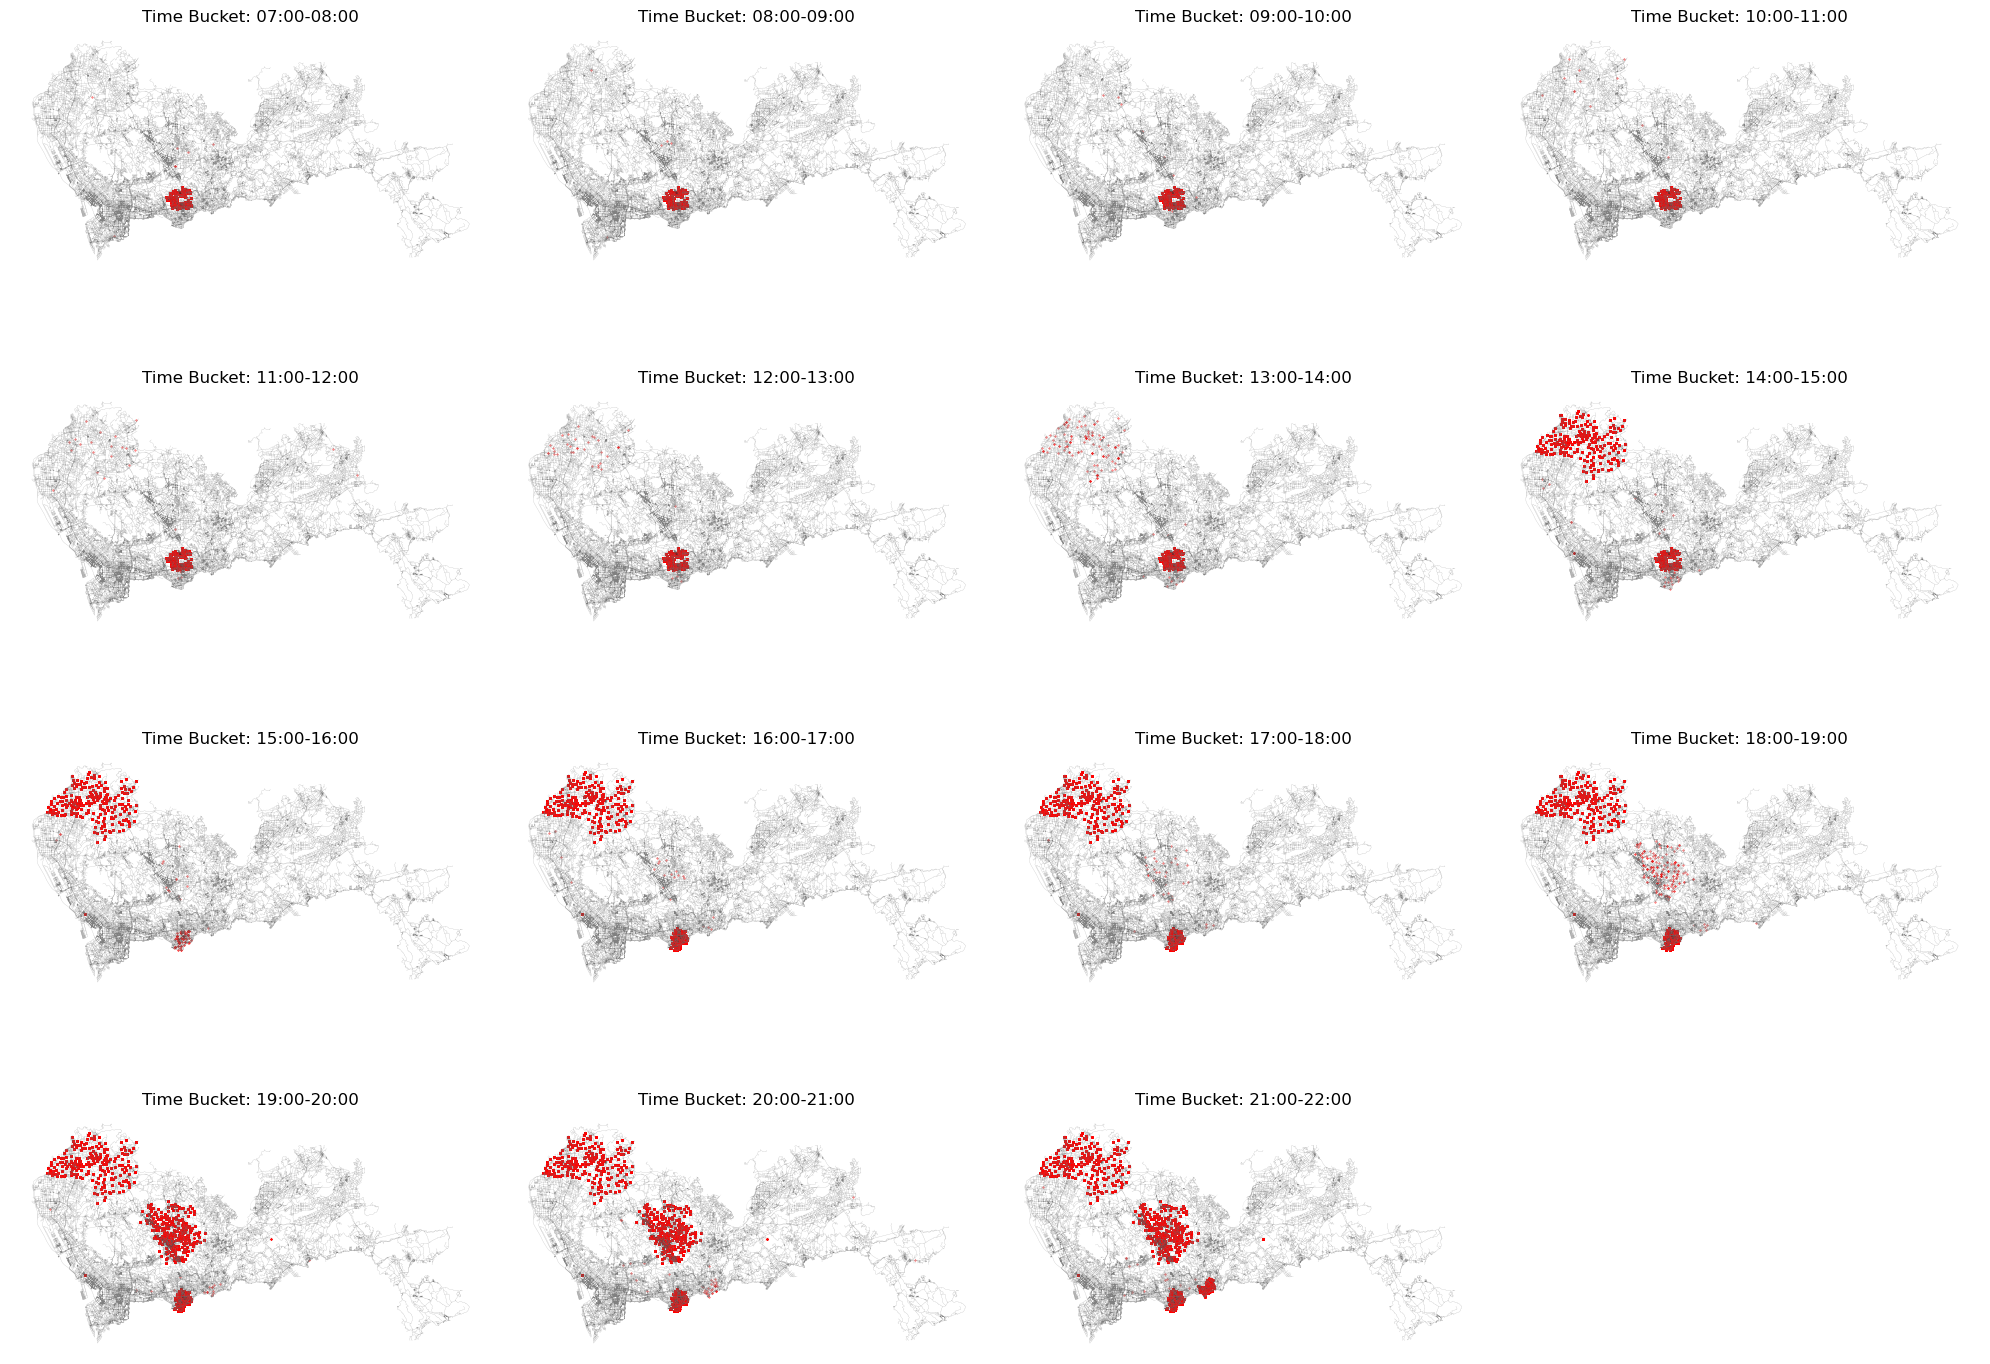

In [96]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Calculate the number of plots (from geo_fil_gps_8 to geo_fil_gps_22)
num_plots = 22 - 8 + 1  # 15 plots

# Create a figure with enough rows and columns to fit all plots
fig, axes = plt.subplots((num_plots + 3) // 4, 4, figsize=(20, 15))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Assume time_slots list or mapping exists mapping indices to time buckets
time_slots = geo_gps_data['time_bucket'].cat.categories.tolist()

# Loop through each subplot to plot geo_fil_gps_i and gdf_edges, starting from geo_fil_gps_8
for i in range(8, 23):  # From geo_fil_gps_8 to geo_fil_gps_22
    ax = axes[i - 8]  # Adjust index for axes array
    # Plot gdf_edges as a background with a light grey color and semi-transparent
    gdf_edges.plot(ax=ax, linewidth=0.1, color='grey', alpha=0.5)
    
    # Dynamically access geo_fil_gps_{i} data using eval (be cautious with eval in production code)
    geo_fil_gps = eval(f'geo_fil_gps_{i}')
    
    # Plot geo_fil_gps on the respective axis with red markers
    geo_fil_gps.plot(ax=ax, marker='o', color='red', markersize=0.1)
    
    # Set title using the corresponding time bucket from time_slots list
    if i <= len(time_slots):  # Ensure index is within the list range
        ax.set_title(f'Time Bucket: {time_slots[i-1]}')
    else:
        ax.set_title(f'Additional Plot {i}')
    
    # Turn off axis display
    ax.axis('off')

# Hide any unused axes
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

# Adjust layout to prevent overlap between subplots
plt.tight_layout()
# Display the plot
plt.show()

In [13]:
import pandas as pd

# Assuming 'geo_fil_gps_x' are your dataframes and they have been defined in your environment.
# Create an empty list to store the counts.
id_counts = []

# Loop through the range of numbers corresponding to your dataframes.
for i in range(7, 23):
    # Dynamically access each dataframe using eval (be cautious with eval, ensure environment safety).
    df = eval(f'geo_fil_gps_{i}')
    # Append the length of the 'id' column of each dataframe to the list.
    id_counts.append(len(df['id']))

# Create a DataFrame from the list of counts.
id_counts_df = pd.DataFrame(id_counts, columns=['ID Counts'])

# Optional: if you want to add a time or label column corresponding to each dataframe:
id_counts_df['Time Bracket'] = [f"{i}:00" for i in range(7, 23)]

In [14]:
id_counts_df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ID Counts,488082,604836,706540,784758,798033,768653,756539,439007,646349,1798374,2408393,2559103,2578514,4101281,4145653,5751002
Time Bracket,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00


In [33]:
gdf_edges = gdf_edges[~gdf_edges['osmid'].apply(lambda x: isinstance(x, list))].reset_index()
gdf_edges = gdf_edges.rename(columns={'index': 'edge_id'})

In [39]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from rtree import index

# Calculate the centroids for each line
unary_union = gdf_edges.unary_union

# Prepare R-tree
idx = index.Index()
for i, geom in enumerate(gdf_edges.geometry):
    idx.insert(i, geom.bounds)

# Create a function
def nearest(row, idx, df1, df2, geom1_col='geometry', src_column=None):
    """Find the nearest line and return the corresponding value from specified column."""
    # Find the nearest points (using the R-tree index)
    nearest_geom_ids = list(idx.nearest((row[geom1_col].x, row[geom1_col].y), 1))
    
    # Initialize the min_distance with a large number
    min_distance = float("inf")
    min_id = None
    for nearest_id in nearest_geom_ids:
        nearest_line = df2.loc[nearest_id].geometry
        distance = nearest_line.distance(Point(row[geom1_col].x, row[geom1_col].y))
        if distance < min_distance:
            min_distance = distance
            min_id = nearest_id

    return df2.loc[min_id][src_column]

# Store the 'id' of the nearest "gdf_edges" points into a new column "nearest_id" in "geo_fil_gps_20"
geo_fil_gps_20['edge_id'] = geo_fil_gps_20.apply(nearest, idx=idx, df1=geo_fil_gps_20, df2=gdf_edges, geom1_col='geometry', src_column='edge_id', axis=1)
geo_fil_gps_20

,id,time,lon,lat,datetime,time_bucket,geometry,edge_id
0,55555556,20:50:17,113.846597,22.772500,2013-10-22 20:50:17,20:00-21:00,POINT (113.84660 22.77250),131898
1,55555576,20:31:48,114.032083,22.627986,2013-10-22 20:31:48,20:00-21:00,POINT (114.03208 22.62799),78227
2,55555583,20:51:43,114.041319,22.633264,2013-10-22 20:51:43,20:00-21:00,POINT (114.04132 22.63326),78096
3,55555588,20:43:08,114.032083,22.627986,2013-10-22 20:43:08,20:00-21:00,POINT (114.03208 22.62799),78227
4,55555594,20:31:38,113.988750,22.681319,2013-10-22 20:31:38,20:00-21:00,POINT (113.98875 22.68132),133972
...,...,...,...,...,...,...,...,...
4101276,55969824,20:31:22,114.056111,22.625764,2013-10-22 20:31:22,20:00-21:00,POINT (114.05611 22.62576),99645
4101277,55969824,20:32:31,114.056111,22.625764,2013-10-22 20:32:31,20:00-21:00,POINT (114.05611 22.62576),99645
4101278,55969825,20:09:15,114.042708,22.524583,2013-10-22 20:09:15,20:00-21:00,POINT (114.04271 22.52458),79716
4101279,55969825,20:09:51,114.042708,22.524583,2013-10-22 20:09:51,20:00-21:00,POINT (114.04271 22.52458),79716


In [52]:
public_transport = pd.read_excel('C:/Users/Admin/Desktop/website/transportation_pois_shenzhen.xlsx')
public_transport_gdf = gpd.GeoDataFrame(
    public_transport, 
    geometry=gpd.points_from_xy(public_transport['WGS84_Lng'], public_transport['WGS84_Lat'])
)


public_transport_gdf.set_crs(epsg=4326, inplace=True)

,名称,大类,中类,小类,地址,省,市,区,WGS84_Lng,WGS84_Lat,geometry
0,华丰数码科技园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.865137,22.822179,POINT (113.86514 22.82218)
1,燕川北部工业园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.865786,22.822697,POINT (113.86579 22.82270)
2,龙侨华工业园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.869303,22.828887,POINT (113.86930 22.82889)
3,松山墓园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.872658,22.829494,POINT (113.87266 22.82949)
4,运辉物流园停车场(出入口),交通设施服务,停车场,停车场出入口,燕罗街道广田路德邦物流西南50米,广东省,深圳市,宝安区,113.874570,22.821861,POINT (113.87457 22.82186)
...,...,...,...,...,...,...,...,...,...,...,...
37530,棕榈湾停车场,交通设施服务,停车场,公共停车场,海景二路1125号,广东省,深圳市,盐田区,114.231461,22.550141,POINT (114.23146 22.55014)
37531,停车场,交通设施服务,停车场,路边停车场,海涛路8号,广东省,深圳市,盐田区,114.227401,22.550506,POINT (114.22740 22.55051)
37532,海涛花园停车场,交通设施服务,停车场,公共停车场,海涛路58号,广东省,深圳市,盐田区,114.229494,22.549198,POINT (114.22949 22.54920)
37533,棕榈湾室内停车场(出入口),交通设施服务,停车场,停车场出入口,海景二路与金融路交叉口南150米,广东省,深圳市,盐田区,114.231446,22.550313,POINT (114.23145 22.55031)


In [57]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from rtree import index

# Calculate the centroids for each line
unary_union = gdf_edges.unary_union

# Prepare R-tree
idx = index.Index()
for i, geom in enumerate(gdf_edges.geometry):
    idx.insert(i, geom.bounds)

# Create a function
def nearest(row, idx, df1, df2, geom1_col='geometry', src_column=None):
    """Find the nearest line and return the corresponding value from specified column."""
    # Find the nearest points (using the R-tree index)
    nearest_geom_ids = list(idx.nearest((row[geom1_col].x, row[geom1_col].y), 1))
    
    # Initialize the min_distance with a large number
    min_distance = float("inf")
    min_id = None
    for nearest_id in nearest_geom_ids:
        nearest_line = df2.loc[nearest_id].geometry
        distance = nearest_line.distance(Point(row[geom1_col].x, row[geom1_col].y))
        if distance < min_distance:
            min_distance = distance
            min_id = nearest_id

    return df2.loc[min_id][src_column]

# Store the 'id' of the nearest "gdf_edges" points into a new column "nearest_id" in "public_transport_gdf"
public_transport_gdf['edge_id'] = public_transport_gdf.apply(nearest, idx=idx, df1=public_transport_gdf, df2=gdf_edges, geom1_col='geometry', src_column='edge_id', axis=1)
public_transport_gdf

,名称,大类,中类,小类,地址,省,市,区,WGS84_Lng,WGS84_Lat,geometry,edge_id
0,华丰数码科技园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.865137,22.822179,POINT (113.86514 22.82218),125670
1,燕川北部工业园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.865786,22.822697,POINT (113.86579 22.82270),125654
2,龙侨华工业园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.869303,22.828887,POINT (113.86930 22.82889),125676
3,松山墓园(公交站),交通设施服务,公交车站,公交车站相关,M260路,广东省,深圳市,宝安区,113.872658,22.829494,POINT (113.87266 22.82949),125676
4,运辉物流园停车场(出入口),交通设施服务,停车场,停车场出入口,燕罗街道广田路德邦物流西南50米,广东省,深圳市,宝安区,113.874570,22.821861,POINT (113.87457 22.82186),123048
...,...,...,...,...,...,...,...,...,...,...,...,...
37530,棕榈湾停车场,交通设施服务,停车场,公共停车场,海景二路1125号,广东省,深圳市,盐田区,114.231461,22.550141,POINT (114.23146 22.55014),170583
37531,停车场,交通设施服务,停车场,路边停车场,海涛路8号,广东省,深圳市,盐田区,114.227401,22.550506,POINT (114.22740 22.55051),178360
37532,海涛花园停车场,交通设施服务,停车场,公共停车场,海涛路58号,广东省,深圳市,盐田区,114.229494,22.549198,POINT (114.22949 22.54920),170163
37533,棕榈湾室内停车场(出入口),交通设施服务,停车场,停车场出入口,海景二路与金融路交叉口南150米,广东省,深圳市,盐田区,114.231446,22.550313,POINT (114.23145 22.55031),169761


In [58]:
road_gps_points = gdf_edges.merge(geo_fil_gps_20,left_on='edge_id',right_on='edge_id',how='left')
edge_id_counts = road_gps_points.groupby('edge_id').size().reset_index(name='count')

In [66]:
road_gps = gdf_edges.merge(edge_id_counts,left_on='edge_id',right_on='edge_id',how='left')

In [67]:
road_gps

,edge_id,osmid,oneway,lanes,name,highway,reversed,length,geometry,ref,bridge,maxspeed,tunnel,access,service,width,junction,count
0,0,97240783,False,2,木棉花街,tertiary,False,9.086,"LINESTRING (114.10450 22.54050, 114.10449 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,97240783,False,2,木棉花街,tertiary,True,204.696,"LINESTRING (114.10450 22.54050, 114.10451 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,193926052,False,NaN,NaN,unclassified,True,176.670,"LINESTRING (114.10450 22.54050, 114.10456 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3,478022251,True,2,嘉宾路,secondary,False,83.743,"LINESTRING (114.10450 22.54050, 114.10454 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,231542499,True,NaN,NaN,trunk_link,False,110.481,"LINESTRING (114.00349 22.53022, 114.00293 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198573,198573,1258133423,False,NaN,NaN,path,True,406.395,"LINESTRING (114.55521 22.52860, 114.55526 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
198574,198574,1258133423,False,NaN,NaN,path,True,394.692,"LINESTRING (114.55494 22.53118, 114.55538 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
198575,198575,1057088031,False,NaN,NaN,path,False,1253.898,"LINESTRING (114.54332 22.53624, 114.54327 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
198576,198576,1057088031,False,NaN,NaN,path,True,62.530,"LINESTRING (114.54332 22.53624, 114.54341 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [68]:
road_transport_points = gdf_edges.merge(public_transport_gdf,left_on='edge_id',right_on='edge_id',how='left')
transport_id_counts = road_transport_points.groupby('edge_id').size().reset_index(name='count')

In [69]:
road_transport = gdf_edges.merge(transport_id_counts,left_on='edge_id',right_on='edge_id',how='left')

In [70]:
road_transport

,edge_id,osmid,oneway,lanes,name,highway,reversed,length,geometry,ref,bridge,maxspeed,tunnel,access,service,width,junction,count
0,0,97240783,False,2,木棉花街,tertiary,False,9.086,"LINESTRING (114.10450 22.54050, 114.10449 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,97240783,False,2,木棉花街,tertiary,True,204.696,"LINESTRING (114.10450 22.54050, 114.10451 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,193926052,False,NaN,NaN,unclassified,True,176.670,"LINESTRING (114.10450 22.54050, 114.10456 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,3,478022251,True,2,嘉宾路,secondary,False,83.743,"LINESTRING (114.10450 22.54050, 114.10454 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,231542499,True,NaN,NaN,trunk_link,False,110.481,"LINESTRING (114.00349 22.53022, 114.00293 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198573,198573,1258133423,False,NaN,NaN,path,True,406.395,"LINESTRING (114.55521 22.52860, 114.55526 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
198574,198574,1258133423,False,NaN,NaN,path,True,394.692,"LINESTRING (114.55494 22.53118, 114.55538 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
198575,198575,1057088031,False,NaN,NaN,path,False,1253.898,"LINESTRING (114.54332 22.53624, 114.54327 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
198576,198576,1057088031,False,NaN,NaN,path,True,62.530,"LINESTRING (114.54332 22.53624, 114.54341 22.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [71]:
road_transport.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [72]:
road_gps.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

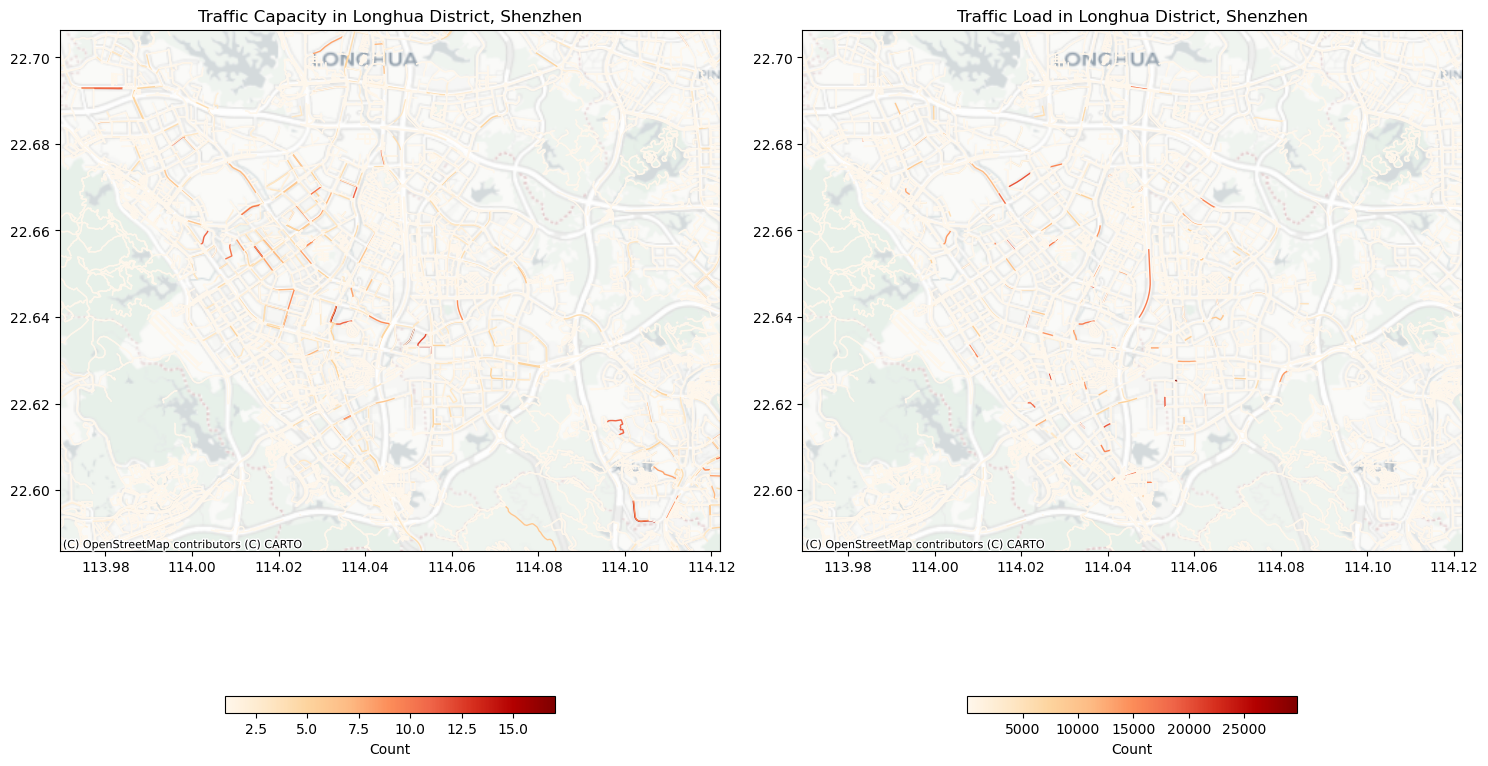

In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Define the bounding box coordinates
left, right, bottom, top = 113.9694, 114.1219, 22.5860, 22.7064

# Clip the road_transport and road_gps datasets to the bounding box
road_transport_clipped = road_transport.cx[left:right, bottom:top]
road_gps_clipped = road_gps.cx[left:right, bottom:top]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Plot the clipped road_transport on the left with colors based on 'count'
road_transport_clipped.plot(column='count', ax=axes[0], legend=True, linewidth=1, cmap='OrRd',
                            legend_kwds={'shrink': 0.5, 'label': 'Count', 'orientation': 'horizontal'})
ctx.add_basemap(axes[0], crs=road_transport_clipped.crs.to_string(), source=ctx.providers.CartoDB.Positron)
axes[0].set_xlim(left, right)
axes[0].set_ylim(bottom, top)
axes[0].set_title('Traffic Capacity in Longhua District, Shenzhen')

# Plot the clipped road_gps on the right with colors based on 'count'
road_gps_clipped.plot(column='count', ax=axes[1], legend=True, linewidth=1, cmap='OrRd',
                      legend_kwds={'shrink': 0.5, 'label': 'Count', 'orientation': 'horizontal'})
ctx.add_basemap(axes[1], crs=road_gps_clipped.crs.to_string(), source=ctx.providers.CartoDB.Positron)
axes[1].set_xlim(left, right)
axes[1].set_ylim(bottom, top)
axes[1].set_title('Traffic Load in Longhua District, Shenzhen')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()